In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

# Simple Data Analysis and Logistic Regression Classification 

## The Pima Indian diabetes

We want to predict whether a vector of text features corresponds to a patient having diabetes

### Attribute Information:

Patterns have 8 numeric features plus a 0-1 class label.

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1) 


More details and actual data available in https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

np.set_printoptions(precision=3)

## Loading Data

In [4]:
f_name = 'pima.csv'
df_pima = pd.read_csv(f_name, sep=',')

print( "num_rows: %d\tnum_columns: %d\n" % (df_pima.shape[0], df_pima.shape[1]) )
print( "Column names:\n", list(df_pima.columns) )

vars   = list(df_pima.columns[ : -1])
target = df_pima.columns[-1]

num_rows: 768	num_columns: 9

Column names:
 ['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age', 'label']


## Data Exploration, Visualization and Correlations

We start by performing descriptive statistics, boxplots and histograms.

The `describe` method gives a quick way to check feature counts and extreme values.

In [5]:
########## describe: basic feature stats

df_pima.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
numPregnant,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
bloodPress,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skinThick,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
massIndex,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
label,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### Removing patients with anomalous features.

There are several suspicious looking variables, for instamce, with 0 values that seem wrong.

We first counHow many 0-valued are there in these variables.

In [6]:
idx_blood_press_ok = df_pima['bloodPress'].values > 0.
idx_glucose_ok = df_pima['glucose'].values > 0.
idx_massIndex_ok = df_pima['massIndex'].values > 0.
idx_skin_ok = df_pima['skinThick'].values > 0.

for name, idx in zip(['bloodPress', 'glucose', 'massIndex', 'skinThick'], [idx_blood_press_ok, idx_glucose_ok, idx_massIndex_ok, idx_skin_ok]):
    print(name, '\t', np.logical_not(idx).sum())

bloodPress 	 35
glucose 	 5
massIndex 	 11
skinThick 	 227


We can safely remove the 0 values of `glucose`, `bloodPress` and `massIndex` and the entire `skinThick`column.

We first `and`the values > 0.

In [7]:
idx_blood_press_ok = df_pima['bloodPress'].values > 0.
idx_glucose_ok = df_pima['glucose'].values > 0.
idx_massIndex_ok = df_pima['massIndex'].values > 0.

idx_ok_all = idx_blood_press_ok
for idx in [idx_glucose_ok, idx_massIndex_ok]:
    idx_ok_all = np.logical_and(idx_ok_all, idx)
    print("quedan", idx_ok_all.sum())

quedan 728
quedan 724


Now remove the `skinThick`column. 

In [8]:
df_pima = df_pima.loc[ idx_ok_all ]
df_pima.drop(labels=['skinThick'], axis='columns', inplace=True)
vars.remove('skinThick')

df_pima.describe().T

,count,mean,std,min,25%,50%,75%,max
numPregnant,724.0,3.866022,3.362803,0.000,1.000,3.000,6.0000,17.00
glucose,724.0,121.882597,30.750030,44.000,99.750,117.000,142.0000,199.00
bloodPress,724.0,72.400552,12.379870,24.000,64.000,72.000,80.0000,122.00
insulin,724.0,84.494475,117.016513,0.000,0.000,48.000,130.5000,846.00
massIndex,724.0,32.467127,6.888941,18.200,27.500,32.400,36.6000,67.10
pedigree,724.0,0.474765,0.332315,0.078,0.245,0.379,0.6275,2.42
age,724.0,33.350829,11.765393,21.000,24.000,29.000,41.0000,81.00
label,724.0,0.343923,0.475344,0.000,0.000,0.000,1.0000,1.00


### Boxplots 

They give the median and 1st and 3rd quartiles plus point to possible outliers.

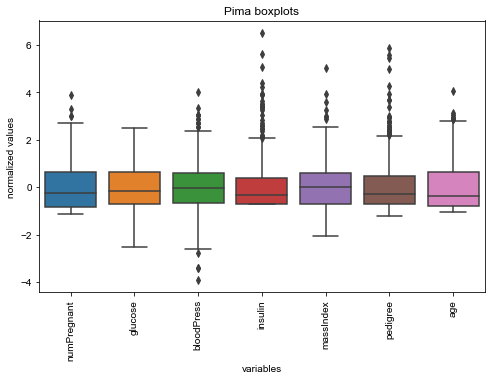

In [9]:
df_pima_normalizado = (df_pima - df_pima.mean()) / df_pima.std() #normalizar para tener rangos uniformes en histogramas

plt.figure( figsize=(8, 5))
plt.title("Pima boxplots")
sns.set_style("white")
bx_plot = sns.boxplot(data=df_pima_normalizado[vars])
plt.xticks(rotation=90)
plt.xlabel("variables")
plt.ylabel("normalized values")
plt.show()

### Histograms and scatterplots

Paired scatter plots between features and diagonal density estimations of features.

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


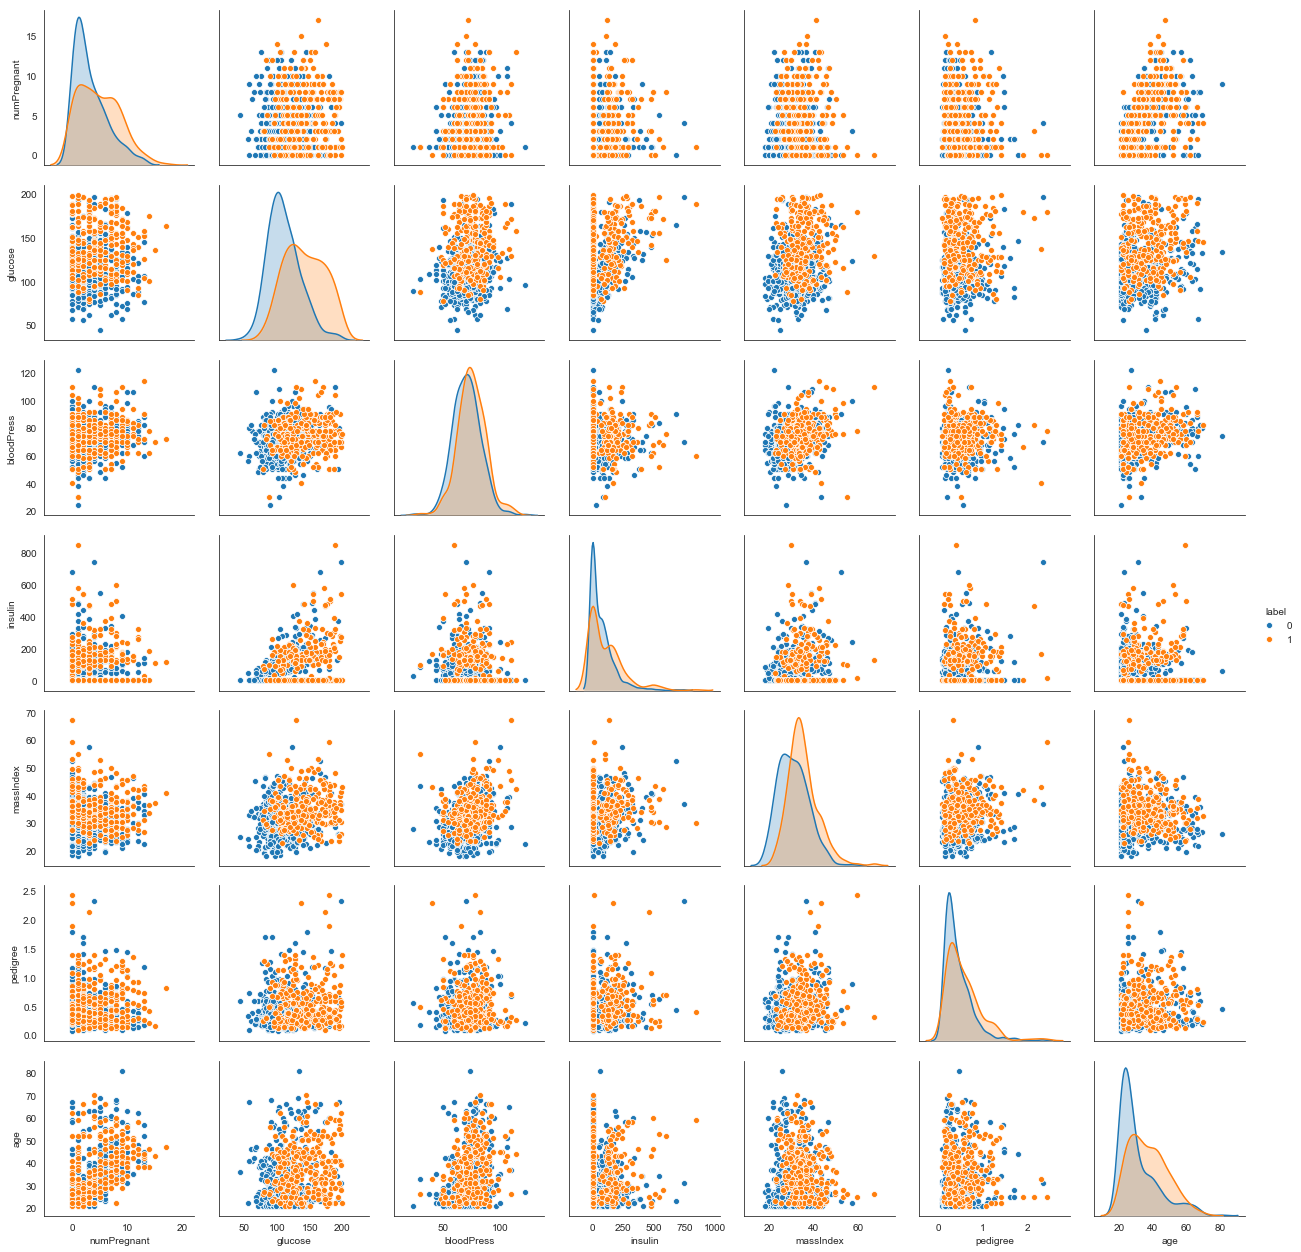

In [10]:
#pair_plot = sns.pairplot(df_pima, vars=vars_pima, hue='label', diag_kind="hist")
pair_plot = sns.pairplot(df_pima, vars=vars, hue='label', diag_kind="kde")
plt.show()

### Positive vs Negative Histograms

Sometimes we want to have more control on our plots. We can get it with a litlle programming.

Let's try to have only the positive and negative histograms together.

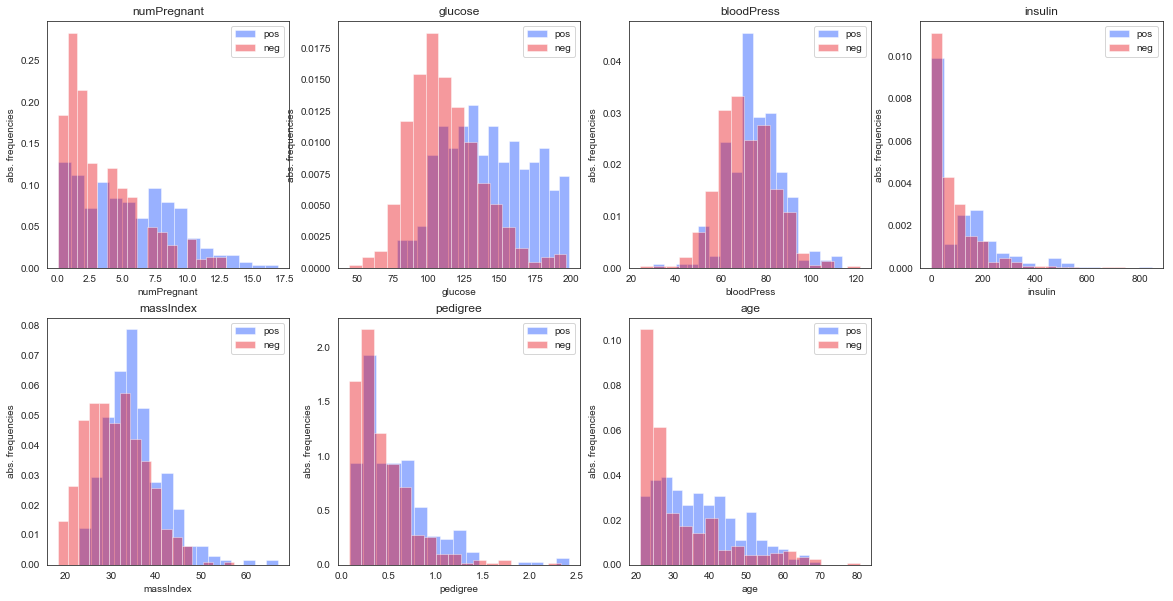

In [11]:
sns.set_color_codes("bright")
sns.set_style("white")

num_columns = 4
num_rows = int( np.ceil( len(df_pima.columns)/num_columns ) )
bins = 17

plt.figure( figsize=(20, 5*num_rows))
plt.title("Pima positive vs negative histograms")

for i, var in enumerate (vars):
    pos = np.where( df_pima[target] == 1)[0]
    neg = np.where( df_pima[target] == 0)[0]

    ax = plt.subplot(num_rows, num_columns, i+1)
    ax.set_title(var)
    #plt.hist( df_pima[ var ].iloc[pos], bins=bins, color='b', label='pos', alpha=0.5)
    #plt.hist( df_pima[ var ].iloc[neg], bins=bins, color='r', label='neg', alpha=0.5)

    sns.distplot( df_pima[ var ].iloc[pos], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
    sns.distplot( df_pima[ var ].iloc[neg], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
    
    plt.ylabel("abs. frequencies")
    plt.legend(loc='best')

plt.show()

**First conclusion**

Postive and negative class histograms are not much separated.
This points to a difficult classification problem.

### Correlations

They are also important in Logistic Regression, but less so for $k$-NN classifiers.

The goal here is to detect collinear features; the correlation with the class labels are usually much less informative,since the labels are essentially arbitrary.

We give them first as a straight table.

In [12]:
df_pima[vars].corr().round(decimals=3)

,numPregnant,glucose,bloodPress,insulin,massIndex,pedigree,age
numPregnant,1.000,0.135,0.210,-0.080,0.012,-0.026,0.557
glucose,0.135,1.000,0.223,0.338,0.223,0.137,0.264
bloodPress,0.210,0.223,1.000,-0.047,0.287,-0.000,0.325
insulin,-0.080,0.338,-0.047,1.000,0.192,0.183,-0.049
massIndex,0.012,0.223,0.287,0.192,1.000,0.155,0.021
pedigree,-0.026,0.137,-0.000,0.183,0.155,1.000,0.023
age,0.557,0.264,0.325,-0.049,0.021,0.023,1.000


We now give them as an annotated heat map.

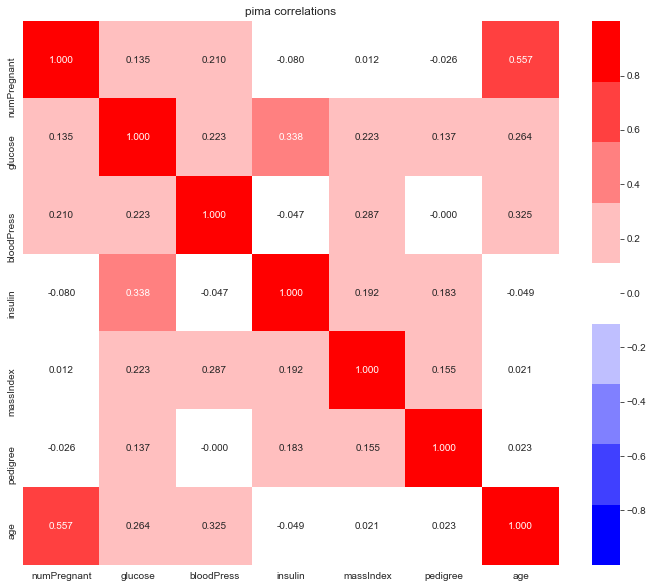

In [13]:
# correlation heatmap
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

plt.figure( figsize=(12, 10))
plt.title('pima correlations')
h_map = sns.heatmap(df_pima[vars].corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    fmt=".3f",
                    xticklabels=vars,
                    yticklabels=vars)

cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

plt.show()

#### Most correlated features

In [14]:
########## rank features according to correlation with targets

print( ( df_pima.corr()['label'].abs().round(3).sort_values(ascending=False).T) )

label          1.000
glucose        0.488
massIndex      0.299
age            0.246
numPregnant    0.224
pedigree       0.185
bloodPress     0.167
insulin        0.145
Name: label, dtype: float64


In [15]:
x = df_pima[vars].values
y = df_pima[target].values

## $k$-NN Classification

We fit a first model without caring too much over the best number of neighbors.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# scale data
std_sc = StandardScaler()
x_sc = std_sc.fit_transform(x)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x, y) 

y_pred = neigh.predict(x_sc)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.656	recall: 0.000	precision: 0.000

confusion matrix:
 [[475   0]
 [249   0]]


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Have to go to the  `KNeighborsClassifier` API page in scikit-learn web to find out what is going on.

### Finding the Optimal $k$ by Cross Validation

In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

l_k = [2**k for k in range(0, 10)]
param_grid = {'n_neighbors': l_k}

#l_weights = ['uniform', 'distance']
#param_grid = {'n_neighbors': l_k, 'weights': l_weights}

n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

neigh = KNeighborsClassifier()

nn_k_search = GridSearchCV(neigh, 
                           param_grid=param_grid, 
                           cv=skf, 
                           scoring='accuracy', 
                           iid=True,
                           refit=True,
                           return_train_score=True, 
                           n_jobs=2, 
                           verbose=1)

t_ini = time.time()
_ = nn_k_search.fit(x, y)
print("CV time: %.2f"  % ((time.time()-t_ini)/60.))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CV time: 0.09


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.1s finished


### Plot of CV accuracies

best_k 16


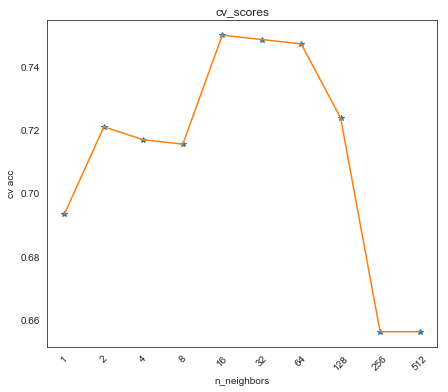

In [18]:
df_nn_k_search = pd.DataFrame.from_dict(nn_k_search.cv_results_)

best_k = nn_k_search.best_params_['n_neighbors']
print("best_k", best_k)

plt.figure(figsize=(7, 6))
plt.title("cv_scores")
plt.xlabel('n_neighbors')
plt.ylabel('cv acc')
plt.xticks(range(len(l_k)), l_k, rotation=45)
_ = plt.plot( df_nn_k_search['mean_test_score'], '*',
              df_nn_k_search['mean_test_score'], '-')
plt.show()

### $k$-NN CV Accuracy, Recall and Precision Scores

In [19]:
best_kNN = nn_k_search.best_estimator_

# accuracies
acc_cv_scores = cross_val_score(best_kNN, x, y, 
                                cv=skf, 
                                scoring='accuracy')

print ("acc_cv_scores:\n\t", acc_cv_scores)
print("\n\tcv_acc_mean: %.3f\n" % (acc_cv_scores.mean()))

# recall
recall_cv_scores = cross_val_score(best_kNN, x, y, 
                                   cv=skf, 
                                   scoring='recall')

print ("recall_cv_scores:\n\t", recall_cv_scores)
print("\n\tcv_recall_mean: %.3f\n" % (recall_cv_scores.mean()))

# precision
prec_cv_scores = cross_val_score(best_kNN, x, y, 
                                 cv=skf, 
                                 scoring='precision')

print ("precision_cv_scores:\n\t", prec_cv_scores)
print("\n\tcv_precisison_mean: %.3f\n" % (prec_cv_scores.mean()))

acc_cv_scores:
	 [0.767 0.685 0.753 0.795 0.74  0.75  0.764 0.778 0.764 0.718]

	cv_acc_mean: 0.751

recall_cv_scores:
	 [0.48  0.44  0.64  0.52  0.44  0.52  0.64  0.56  0.4   0.458]

	cv_recall_mean: 0.510

precision_cv_scores:
	 [0.667 0.667 0.812 0.714 0.727 0.818 0.818 0.684 0.692 0.588]

	cv_precisison_mean: 0.719



## Logistic Regression

In all cases we use l2 penalty and the `lbfgs` solver.

### Tuning `C` in Logistic Regression

**Important**: $\frac{1}{C}$ here is more or less the equivalent of ${\alpha}$ in the notes. 

We estimate the optimal `C` again by CV.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

sc = StandardScaler()
logr = LogisticRegression(solver='lbfgs', max_iter=500)

logr_estimator = Pipeline([('std_sc', sc), 
                           ('logr', logr)])

l_C     = [10.**k for k in range(-5, 5)] 
param_grid ={'logr__C': l_C}

n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True)

C_search = GridSearchCV(logr_estimator, 
                        param_grid=param_grid, 
                        cv=skf, 
                        scoring='accuracy', 
                        refit=True,
                        n_jobs=2,
                        return_train_score=True,
                        verbose=1)

t_0 = time.time()
C_search.fit(x, y)
print("grid_search_time:", (time.time() - t_0)/60.)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


grid_search_time: 0.006346070766448974


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.3s finished


### Analyzing the CV results

We plot the CV errors to check on the adequacy of the best hyperparameter.

best C: 1.0000 acc: 0.775


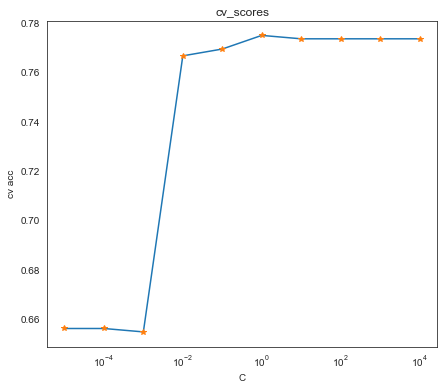

In [21]:
best_C = C_search.best_params_['logr__C']
print("best C: %.4f" % best_C, "acc: %.3f" % C_search.best_score_) 

df_C_search = pd.DataFrame.from_dict(C_search.cv_results_)

plt.figure(figsize=(7, 6))

plt.title("cv_scores")
plt.xlabel('C')
plt.ylabel('cv acc')
plt.xscale('log')
_ = plt.plot( df_C_search['param_logr__C'], df_C_search['mean_test_score'], '-')
_ = plt.plot( df_C_search['param_logr__C'], df_C_search['mean_test_score'], '*')
plt.show()

### Best model performance

We evaluate it using `cross_validate` over accuracy, recall and precision.

In [22]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedShuffleSplit, cross_validate

logr_best = C_search.best_estimator_

n_splits  = 20
test_size = 0.25
scoring = ['accuracy', 'precision', 'recall']   

ssf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
logr_scores = cross_validate(logr_best, x, y, cv=ssf, scoring=scoring)

logr_scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_precision', 'train_precision', 'test_recall', 'train_recall'])

In [23]:
print("logr_acc_mean:    %.2f" % (100.*(logr_scores['test_accuracy'].mean())))
print("lofr_recall_mean: %.2f" % (100.*(logr_scores['test_recall'].mean())))
print("logr_prec_mean:   %.2f" % (100.*(logr_scores['test_precision'].mean())))

logr_acc_mean:    77.04
lofr_recall_mean: 54.84
logr_prec_mean:   71.70


## Predicting probabilities

In classification we should give **class probability estimates** rather than labels.

Moreover, doing so, we can build the histogram of the posterior probabilities predicted for the positive class and decide on **adequate thresholds**.

In [24]:
######### plot prob histograms
from sklearn.model_selection import cross_val_predict

p_pred_logr = cross_val_predict(logr_best, x, y, cv=skf,
                                method='predict_proba')

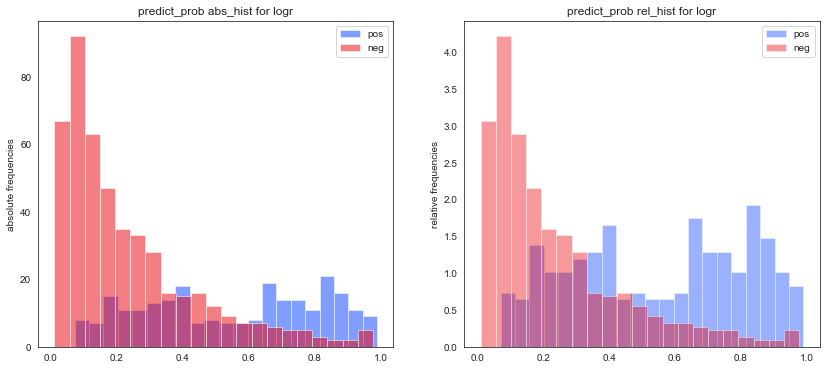

In [25]:
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]

bins = 21

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("predict_prob abs_hist for logr")
plt.ylabel("absolute frequencies")
plt.hist( p_pred_logr[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_logr[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title("predict_prob rel_hist for logr")
plt.ylabel("relative frequencies")
sns.distplot( p_pred_logr[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
sns.distplot( p_pred_logr[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

plt.show()

### Applying classification models

Diabetes is a serious illness so we should try to improve recall as much as possible taking also into account our resources.

We explore the effect on the classification performance of lowering the decision threshold for positives below 0.5.

In [26]:
######### threshold analysis
num_patterns = x.shape[0]
l_thresholds = [0.5, 0.4, 0.3, 0.2]

for thresh in l_thresholds:
    y_pred_thresh = np.zeros( num_patterns ) 
    pos_thresh = np.where(p_pred_logr[ :, 1] > thresh)[0]
    y_pred_thresh[pos_thresh] = 1

    print("threshold:", thresh)
    print("\tconfusion matrix\n", confusion_matrix(y, y_pred_thresh) )
    print("\n\taccuracy\t%.3f"    %   accuracy_score(y, y_pred_thresh) )
    print("\trecall\t\t%.3f"      %   recall_score(y, y_pred_thresh) )
    print("\tprecision\t%.3f"     %   precision_score(y, y_pred_thresh) )
    print("\tnum_alertas\t%d\n\n" %   confusion_matrix(y, y_pred_thresh)[ : , 1 ].sum() )    

threshold: 0.5
	confusion matrix
 [[419  56]
 [112 137]]

	accuracy	0.768
	recall		0.550
	precision	0.710
	num_alertas	193


threshold: 0.4
	confusion matrix
 [[386  89]
 [ 87 162]]

	accuracy	0.757
	recall		0.651
	precision	0.645
	num_alertas	251


threshold: 0.3
	confusion matrix
 [[347 128]
 [ 57 192]]

	accuracy	0.744
	recall		0.771
	precision	0.600
	num_alertas	320


threshold: 0.2
	confusion matrix
 [[274 201]
 [ 30 219]]

	accuracy	0.681
	recall		0.880
	precision	0.521
	num_alertas	420




### Conclusions

Classification is conceptually "harder" than regression: 

* The classification goal is subtler than the one for regression.

* There are several ways/measures to evaluate a classification model.

* There may be different goals to be achieved by s single model.

* There may be different criteria to choose prediction thresholds.

* **Classification probabilities** are more important and useful than predicted labels.